In [20]:
import numpy as np
import qcodes as qc
import os
from qcodes import (Measurement,
                    experiments,
                    initialise_database,
                    initialise_or_create_database_at,
                    load_by_guid,
                    load_by_run_spec,
                    load_experiment,
                    load_last_experiment,
                    load_or_create_experiment,
                    new_experiment,
                    ManualParameter)
import matplotlib.pyplot as plt

In [8]:
db_name = "GeSiNW_Qubit_VTI01_Jonas.db" # Database name
sample_name = "Butch" # Sample name
exp_name = "Qubit_Search" # Experiment name

db_file_path = os.path.join(os.getcwd(), db_name)
qc.config.core.db_location = db_file_path
initialise_or_create_database_at(db_file_path)

experiment = load_or_create_experiment(experiment_name = exp_name,
                                       sample_name = sample_name)

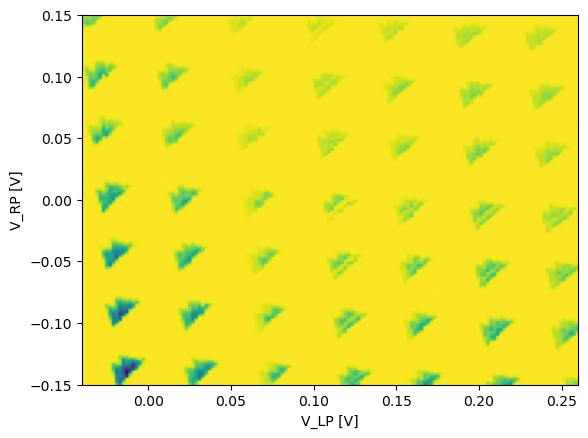

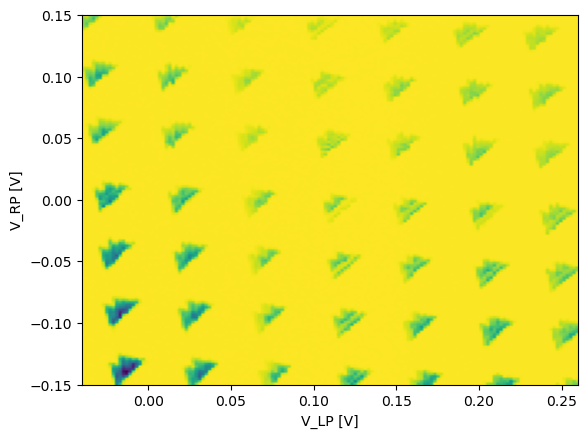

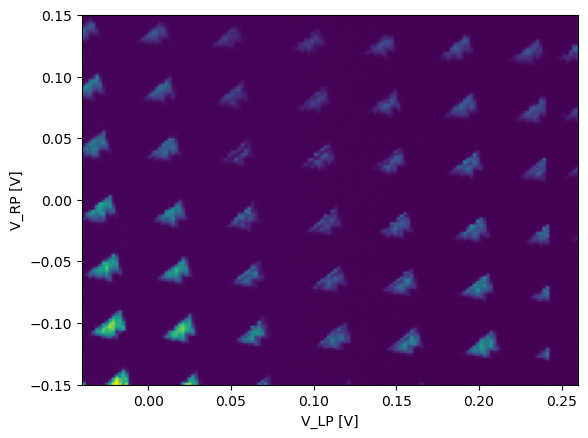

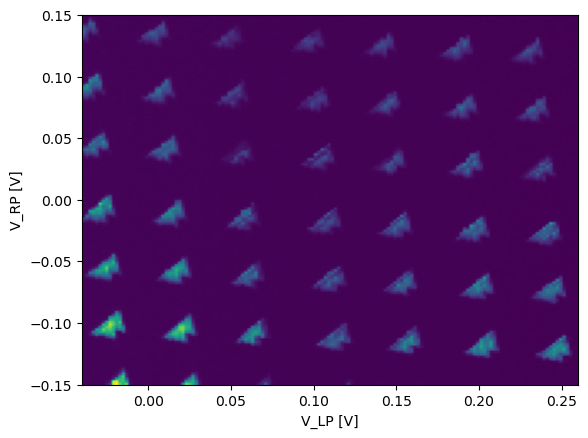

In [14]:
data_with_magnet = load_by_run_spec(captured_run_id=5).to_xarray_dataset()
data_without_magnet = load_by_run_spec(captured_run_id=6).to_xarray_dataset()

data_with_magnet_neg_bias = load_by_run_spec(captured_run_id=7).to_xarray_dataset()
data_without_magnet_neg_bias = load_by_run_spec(captured_run_id=8).to_xarray_dataset()

# isd = data['I_SD']

def plot_qcodes_data(data):
    isd = data['I_SD']

    axes_values = []
    axes_values_names = []
    axes_units = []
    for item, n in dict(data.dims).items():
        axes_values.append(data[item].to_numpy())
        axes_values_names.append(data[item].long_name)
        axes_units.append(data[item].unit)

    plt.imshow(isd.T, origin='lower', aspect = 'auto', extent = [axes_values[0].min(), axes_values[0].max(), axes_values[1].min(), axes_values[1].max()])
    plt.xlabel(axes_values_names[0]+' ['+axes_units[0]+']')
    plt.ylabel(axes_values_names[1]+' ['+axes_units[1]+']')
    plt.show()

plot_qcodes_data(data_with_magnet)
plot_qcodes_data(data_without_magnet)

plot_qcodes_data(data_with_magnet_neg_bias)
plot_qcodes_data(data_without_magnet_neg_bias)


In [15]:
# consider positive bias case

In [16]:
from btriangle_location_detection import get_locations

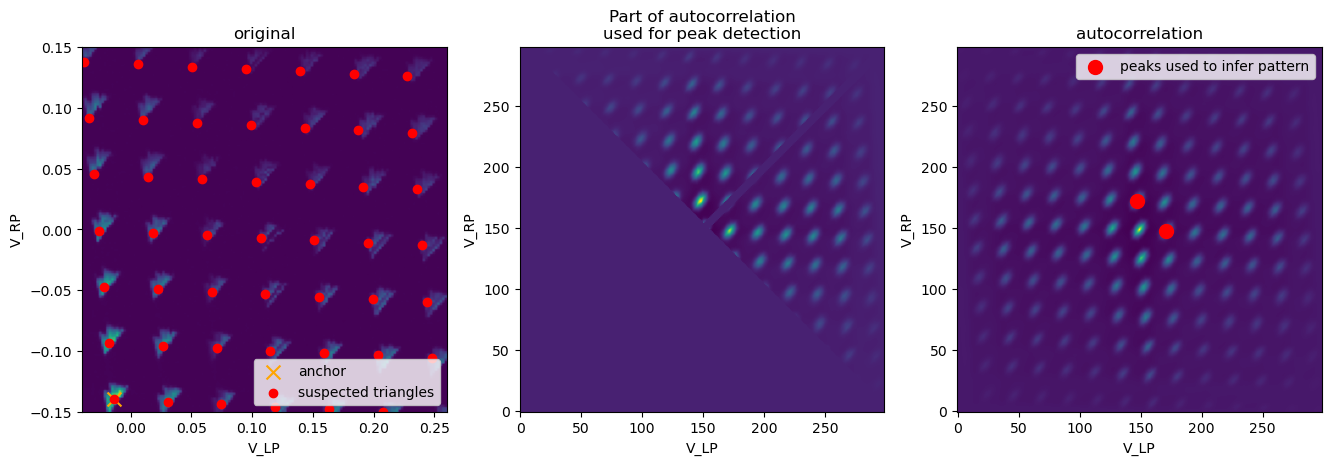

In [24]:
data_I_SD = data_with_magnet['I_SD']
data_I_SD_low_magnet = data_without_magnet['I_SD']
data = data_with_magnet


axes_values = []
axes_values_names = []
axes_units = []
for item, n in dict(data.dims).items():
    axes_values.append(data[item].to_numpy())
    axes_values_names.append(data[item].long_name)
    axes_units.append(data[item].unit)


x_array = axes_values[0]
y_array = axes_values[1]

x_name = axes_values_names[0]
y_name = axes_values_names[1]

anchor, peaks_px, peaks, all_triangles_px, all_triangles, fig = get_locations(-data_I_SD.to_numpy().T, x_array, y_array, x_name, y_name, return_figure = True, plot=True)

In [34]:
def cutout(img: np.ndarray, blob: np.ndarray, sidelength: int = 50) -> np.ndarray:
    """
    Cuts out a square region from the image centered around the blob.

    Args:
        img (np.ndarray): The input image.
        blob (np.ndarray): The blob around which to cut out.
        sidelength (int, optional): The sidelength of the square to cut out. Defaults to 50.

    Returns:
        np.ndarray: The cut out image.
    """
    x_bottom = (
        int(blob[0] - sidelength / 2) if int(blob[0] - sidelength / 2) >= 0 else 0
    )
    x_top = int(blob[0] + sidelength / 2) if int(blob[0] + sidelength / 2) >= 0 else 0
    y_bottom = (
        int(blob[1] - sidelength / 2) if int(blob[1] - sidelength / 2) >= 0 else 0
    )
    y_top = int(blob[1] + sidelength / 2) if int(blob[1] + sidelength / 2) >= 0 else 0
    img_save = img.copy()
    img = img[x_bottom:x_top, y_bottom:y_top]
    while img.shape[0] != img.shape[1]:
        sidelength -= 1
        img = cutout(img_save, blob, sidelength)
    return img

In [35]:
sidelength = np.max(peaks_px)

In [56]:
from btriangle_detection import PSB_detector, triangle_segmentation_alg
from btriangle_properties import detect_base
#

img_high_magnet = -data_I_SD.to_numpy().T
img_low_magnet = -data_I_SD_low_magnet.to_numpy().T

PSB_List = []
intensity_pairs = []
intensity_diff = []
for location in all_triangles_px:
    img_block_cutout = cutout(img_low_magnet, location, sidelength= sidelength)
    img_leak_cutout = cutout(img_high_magnet, location, sidelength= sidelength)
    if img_block_cutout.shape[0] == sidelength and img_block_cutout.shape[1] == sidelength:
        # print(f'img_leak_cutout.shape {img_leak_cutout.shape}')
        unblocked, ims, masks = triangle_segmentation_alg(img_leak_cutout,res = 2,min_area = 25, thr_method = 'noisy_binary', denoising = True, allow_MET = True, direction = 'down')
        base, corner_pts, c_im = detect_base(unblocked, masks, 'down')

        blocked,ims2, masks2 = triangle_segmentation_alg(img_block_cutout,res = 2,min_area = 25, thr_method = 'noisy_binary', denoising = True,allow_MET = True, direction = 'down')

        pair, PSB = PSB_detector(unblocked, blocked, base, masks, 'down', int_tol = 0.1)
        intensity_pairs.append(pair)
        # intensity_diff.append(abs(pair[0]-pair[1]))
        PSB_List.append(int(PSB))
    else:
        PSB_List.append(None)
        intensity_pairs.append(None)
        # intensity_diff.append(None)

PSB_N = np.array(PSB_List)



No lines found, potentially increase tolerance for slope deviation.
No lines found, potentially increase tolerance for slope deviation.
No lines found, potentially increase tolerance for slope deviation.
No lines found, potentially increase tolerance for slope deviation.
No lines found, potentially increase tolerance for slope deviation.


/Users/jonasschuff/Documents/Projects/Colab with MindFoundry/mf-ou/bias_triangle_detection/btriangle_properties.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = lstsq(A, y_coords)[0]


In [55]:
intensity_pairs

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 [],
 (1.3049647473560517, 1.3412859459280586),
 [],
 [],
 (1.194988856174578, 1.1886775546628814),
 None,
 None,
 [],
 (1.3383348458216628, 1.3581748488869232),
 (1.159715085747688, 1.159431093088437),
 [],
 [],
 None,
 None,
 [],
 [],
 [],
 [],
 [],
 [],
 None,
 (1.2789754394625952, 1.3030073263981674),
 [],
 [],
 [],
 [],
 [],
 None,
 [],
 (1.256522527802196, 1.2672224338086975),
 [],
 [],
 [],
 [],
 None,
 None,
 None,
 None,
 [],
 [],
 []]

In [57]:

from skimage.draw import rectangle_perimeter
import seaborn
def draw_boxes_and_preds(
    _img: np.ndarray, _img_blocked, locations: np.ndarray, predictions=None, sidelength: int=20, classification_thresh=0.5,
        marker_offset = 5
) -> np.ndarray:
    """
    Function to draw a single box on an image in pixel space.

    Parameters:
    _img (np.ndarray): The image on which the box is to be drawn.
    box (np.ndarray): The coordinates of the box to be drawn.
    condition (str): Determines the color of the box. If 'positive bias', the color is set to the maximum color in the image. Otherwise, it's set to the minimum color in the image.

    Returns:
    np.ndarray: The image with the box drawn on it.
    """
    img = _img.copy()
    img_blocked = _img_blocked.copy()

    for location, pred in zip(locations,predictions):
        start = location-sidelength//2
        end = location+sidelength//2
        # print(f'start {start}')
        # print(f'end {end}')
        rr, cc = rectangle_perimeter(start, end=end, shape=img.shape)
        if pred is None:
            img[rr, cc] = np.mean(img)
            img_blocked[rr, cc] = np.mean(img_blocked)
        elif pred>classification_thresh:
            img[rr, cc] = np.max(img)
            img_blocked[rr, cc] = np.max(img_blocked)
        elif pred<classification_thresh:
            img[rr, cc] = np.percentile(img,90)
            img_blocked[rr, cc] = np.percentile(img_blocked, 90)



    fig, axs = plt.subplots(1,2, figsize = (10,5))

    axs[0].imshow(img, origin = 'lower', cmap = 'icefire')
    # for location, pred in zip(locations,predictions):
    #     if pred is not None:
    #         if pred>classification_thresh:
    #             color='green'
    #         else:
    #             color='red'
    #         print(f'locaation{location[1], location[0]}')
    #         axs[0].annotate(np.round(pred[0],4), (location[1]-marker_offset, location[0]+marker_offset), c=color)
    axs[0].set_title('high B (leaky)')

    axs[1].imshow(img_blocked, origin = 'lower', cmap = 'icefire')
    axs[1].set_title('low B (blocked)')
    axs[0].grid(False)
    axs[1].grid(False)
    plt.tight_layout()
    plt.suptitle('PSB predictions via neural networks')
    return fig



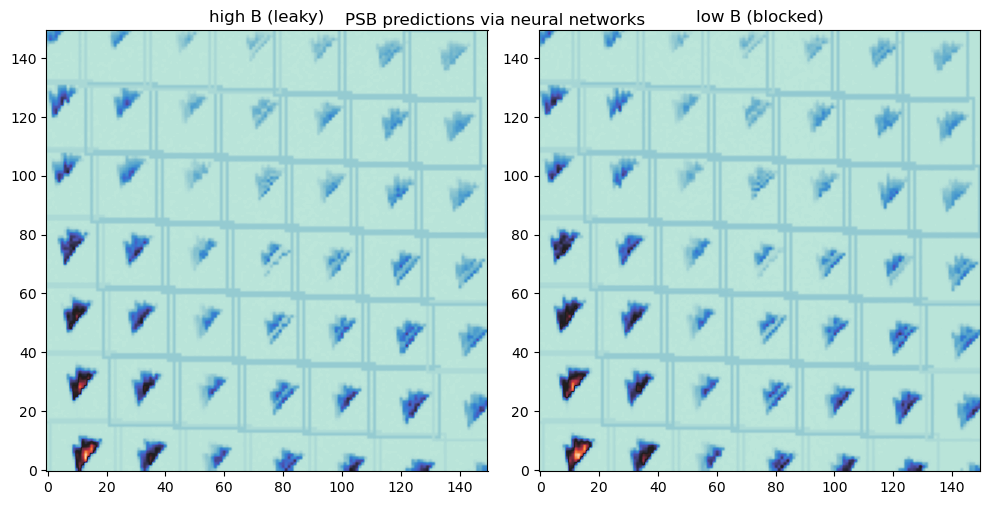

In [58]:
predictions = PSB_N
fig = draw_boxes_and_preds(img_high_magnet, img_low_magnet, all_triangles_px, predictions, sidelength)
plt.show()